<a href="https://colab.research.google.com/github/BrunoAzambuja/Previsao_e_detecao_de_falha_de_motores_a_jato_Turbofan_da_NASA/blob/main/Previs%C3%A3o_e_detec%C3%A7%C3%A3o_de_falha_de_motores_a_jato_Turbofan_da_NASA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Previsão e detecção de falha de motores a jato Turbofan da NASA
#### Modelos preditivos de regressão e classificação para previsão de degradação (RUL) e detecção de anomalias.

*by [Bruno Azambuja](https://www.brunoazambuja.com/m)*


<p align=center>  <img src="https://www.researchgate.net/publication/334737601/figure/fig1/AS:785956336590848@1564398001505/Cross-section-of-a-turbofan-engine-1.ppm" width="50%"></p>

# Business problem

Durante sua vida útil, os componentes das aeronaves são suscetíveis à degradação, o que afeta diretamente seu desempenho e confiabilidade. Prognósticos e **gerenciamento de vida útil** é um tópico importante na indústria para prever o estado dos ativos para evitar tempo de inatividade e falhas em um contexto onde não há margens para erros.

Este estudo é a versão dos dados públicos da **NASA** utilizados para modelagem de degradação dos ativos. Este dataset inclui dados simulados **Run-to-Failure de motores a jato Turbofan** fornecido pela Prognostics CoE da NASA Ames. Um motor Turbofan é a variação mais moderna do motor básico de turbina a gás, conhecido pelo seu alto empuxo e boa eficiência de combustível. 

A **simulação da degradação do motor** foi realizada utilizando diferentes combinações de condições operacionais e modos de falha. Os dados foram registrados através de vários **canais de sensores para caracterizar a evolução da falha**.

# Entendendo os objetivos

Os objetivos deste estudo são desenvolver **modelos de regressão** como ferramenta de previsão da vida útil restante (RUL) de cada motor, assim como **modelos de classificação** como forma de categorização dos motores sob as seguintes classes de RUL: risco alto e baixo do motor apresentar uma falha.

Com isso, buscamos prever o número de ciclos operacionais restantes antes da falha, além disso, este estudo visa à contextualização do problema e à **análise completa dos dados**, para que nos indiquem a abordagem mais adequada da manutenção destes motores.

# Instalando as bibliotecas

Primeiramente vamos instalar as bibliotecas e importar todos os pacotes necessários para este estudo.

In [ ]:
# instalando bibliotecas
!pip install shap
!pip install scikit-plot

In [ ]:
# importando os pacotes necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import warnings
import shap
import joblib

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer
from xgboost import XGBRegressor
from sklearn.ensemble import ExtraTreesRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import f1_score, plot_confusion_matrix, classification_report, ConfusionMatrixDisplay
from scikitplot.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler

np.random.seed(34)
warnings.filterwarnings('ignore')

# Importando os dados

Os conjuntos de dados consistem em **séries temporais multivariadas**. O conjunto de dados é **dividido em subconjuntos de treinamento e teste**. Cada série temporal é de um motor diferente, ou seja, os dados podem ser considerados de uma frota de motores do mesmo tipo. 

O motor está operando normalmente no início de cada série temporal, e desenvolve uma falha em algum momento durante a série. No conjunto de treinamento, a falha cresce em magnitude até a falha do sistema. No conjunto de testes, a série temporal termina algum tempo antes da falha do sistema. 

Os dados são fornecidos como um arquivo de texto com 26 colunas de números, separados por espaços. Cada linha é um instante de dados tirados durante um único ciclo operacional, cada coluna é uma variável diferente.

In [ ]:
# definindo os nomes das features
index_names = ['engine_number', 'cycle_number']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names=[ "sensor_fan_inlet_temperature_(◦R)",
            "sensor_LPC_outlet_temperature_(◦R)",
            "sensor_HPC_outlet_temperature_(◦R)",
            "sensor_LPT_outlet_temperature_(◦R)",
            "sensor_fan_inlet_pressure_(psia)",
            "sensor_bypass_duct_pressure_(psia)",
            "sensor_HPC_outlet_pressure_(psia)",
            "sensor_physical_fan_speed_(rpm)",
            "sensor_physical_core_speed_(rpm)",
            "sensor_engine_pressure ratio_(P50/P2)",
            "sensor_HPC_outlet_static_pressure_(psia)",
            "sensor_ratio_of_fuel_flow_to_Ps30_(pps/psia)",
            "sensor_corrected_fan_speed_(rpm)",
            "sensor_corrected_core_speed_(rpm)",
            "sensor_bypass_ratio",
            "sensor_burner_fuel_air_ratio",
            "sensor_bleed_enthalpy",
            "sensor_required_fan_speed",
            "sensor_required_fan_conversion_speed",
            "sensor_high_pressure_turbines_cool_air_flow",
            "sensor_low_pressure turbines_cool_air_flow" ]
col_names = index_names + setting_names + sensor_names

Significado e função de alguns componentes:

* compressor de baixa pressão (LPC), fornecem gases comprimidos de alta temperatura e alta pressão ao combustor;
* compressor de alta pressão (HPC), fornecem gases comprimidos de alta temperatura e alta pressão ao combustor;
* turbina de baixa pressão (LPT), pode desacelerar e pressurizar o ar para melhorar a eficiência da conversão de energia química do querosene de aviação;
* turbinas de alta pressão (HPT), geram energia mecânica usando pás de turbina de gás de alta temperatura e alta pressão.

In [ ]:
# importando os dados para dataframes
df_train = pd.read_csv('/content/train_FD001.txt',sep='\s+',header=None,index_col=False,names=col_names)
df_test = pd.read_csv('/content/test_FD001.txt',sep='\s+',header=None,index_col=False,names=col_names)
df_test_RUL = pd.read_csv('/content/RUL_FD001.txt',sep='\s+',header=None,index_col=False,names=['RUL'])

# Exploratory Data Analysis (EDA)

Esta etapa foi dividida entre tópicos que visam tirar insights e elevar a consciência situacional a respeito do *dataframe*. Sendo assim, a análise exploratória tem por objetivo permitir um entendimento de como os dados estão estruturados.

Este é um processo crítico que visa realizar investigações iniciais nos dados para descobrir padrões, detectar anomalias, testar hipóteses e verificar suposições com a ajuda de estatísticas resumidas e representações gráficas.

###**Características**

A fim de começar este projeto, irei verificar a integridade e usabilidade do dataset. Com os dados tratados, conseguimos fazer uma análise exploratória identificando suas principais caracteríscas. Para isso, deixarei impresso as primeiras e últimas entradas de dados, os nomes das colunas, os tipos de variáveis por coluna, e a quantidade de dados ausentes.

In [ ]:
# vendo as primeiras e últimas entradas
df_train

,engine_number,cycle_number,setting_1,setting_2,setting_3,sensor_fan_inlet_temperature_(◦R),sensor_LPC_outlet_temperature_(◦R),sensor_HPC_outlet_temperature_(◦R),sensor_LPT_outlet_temperature_(◦R),sensor_fan_inlet_pressure_(psia),...,sensor_ratio_of_fuel_flow_to_Ps30_(pps/psia),sensor_corrected_fan_speed_(rpm),sensor_corrected_core_speed_(rpm),sensor_bypass_ratio,sensor_burner_fuel_air_ratio,sensor_bleed_enthalpy,sensor_required_fan_speed,sensor_required_fan_conversion_speed,sensor_high_pressure_turbines_cool_air_flow,sensor_low_pressure turbines_cool_air_flow
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640


In [ ]:
# vendo as primeiras e últimas entradas
df_test

,engine_number,cycle_number,setting_1,setting_2,setting_3,sensor_fan_inlet_temperature_(◦R),sensor_LPC_outlet_temperature_(◦R),sensor_HPC_outlet_temperature_(◦R),sensor_LPT_outlet_temperature_(◦R),sensor_fan_inlet_pressure_(psia),...,sensor_ratio_of_fuel_flow_to_Ps30_(pps/psia),sensor_corrected_fan_speed_(rpm),sensor_corrected_core_speed_(rpm),sensor_bypass_ratio,sensor_burner_fuel_air_ratio,sensor_bleed_enthalpy,sensor_required_fan_speed,sensor_required_fan_conversion_speed,sensor_high_pressure_turbines_cool_air_flow,sensor_low_pressure turbines_cool_air_flow
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,...,520.69,2388.00,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974
13092,100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,...,521.05,2388.09,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771
13093,100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,...,521.18,2388.04,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051
13094,100,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,...,521.33,2388.08,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699


Quando inspecionamos as estatísticas descritivas de `engine_number`, podemos ver que o conjunto de dados tem um total de 20.631 e 13.096 linhas respectivamente, os números das unidades começam em 1 e terminam em 100 conforme o esperado. 

In [ ]:
# checando as caracteriticas dos dados
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 26 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   engine_number                                 20631 non-null  int64  
 1   cycle_number                                  20631 non-null  int64  
 2   setting_1                                     20631 non-null  float64
 3   setting_2                                     20631 non-null  float64
 4   setting_3                                     20631 non-null  float64
 5   sensor_fan_inlet_temperature_(◦R)             20631 non-null  float64
 6   sensor_LPC_outlet_temperature_(◦R)            20631 non-null  float64
 7   sensor_HPC_outlet_temperature_(◦R)            20631 non-null  float64
 8   sensor_LPT_outlet_temperature_(◦R)            20631 non-null  float64
 9   sensor_fan_inlet_pressure_(psia)              20631 non-null 

In [ ]:
# checando as caracteriticas dos dados
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13096 entries, 0 to 13095
Data columns (total 26 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   engine_number                                 13096 non-null  int64  
 1   cycle_number                                  13096 non-null  int64  
 2   setting_1                                     13096 non-null  float64
 3   setting_2                                     13096 non-null  float64
 4   setting_3                                     13096 non-null  float64
 5   sensor_fan_inlet_temperature_(◦R)             13096 non-null  float64
 6   sensor_LPC_outlet_temperature_(◦R)            13096 non-null  float64
 7   sensor_HPC_outlet_temperature_(◦R)            13096 non-null  float64
 8   sensor_LPT_outlet_temperature_(◦R)            13096 non-null  float64
 9   sensor_fan_inlet_pressure_(psia)              13096 non-null 

Podemos ver que todas as variáveis estão com seu formato ajustado não necessitando transformações das *features*.

In [ ]:
# gerando a lista de valores únicos
print("Valores únicos (por coluna):\n{}\n".format(df_train.nunique()))

Valores únicos (por coluna):
engine_number                                    100
cycle_number                                     362
setting_1                                        158
setting_2                                         13
setting_3                                          1
sensor_fan_inlet_temperature_(◦R)                  1
sensor_LPC_outlet_temperature_(◦R)               310
sensor_HPC_outlet_temperature_(◦R)              3012
sensor_LPT_outlet_temperature_(◦R)              4051
sensor_fan_inlet_pressure_(psia)                   1
sensor_bypass_duct_pressure_(psia)                 2
sensor_HPC_outlet_pressure_(psia)                513
sensor_physical_fan_speed_(rpm)                   53
sensor_physical_core_speed_(rpm)                6403
sensor_engine_pressure ratio_(P50/P2)              1
sensor_HPC_outlet_static_pressure_(psia)         159
sensor_ratio_of_fuel_flow_to_Ps30_(pps/psia)     427
sensor_corrected_fan_speed_(rpm)                  56
sensor_corrected_

In [ ]:
# gerando a lista de valores únicos
print("Valores únicos (por coluna):\n{}\n".format(df_test.nunique()))

Valores únicos (por coluna):
engine_number                                    100
cycle_number                                     303
setting_1                                        150
setting_2                                         14
setting_3                                          1
sensor_fan_inlet_temperature_(◦R)                  1
sensor_LPC_outlet_temperature_(◦R)               262
sensor_HPC_outlet_temperature_(◦R)              2361
sensor_LPT_outlet_temperature_(◦R)              2954
sensor_fan_inlet_pressure_(psia)                   1
sensor_bypass_duct_pressure_(psia)                 2
sensor_HPC_outlet_pressure_(psia)                415
sensor_physical_fan_speed_(rpm)                   41
sensor_physical_core_speed_(rpm)                4047
sensor_engine_pressure ratio_(P50/P2)              1
sensor_HPC_outlet_static_pressure_(psia)         136
sensor_ratio_of_fuel_flow_to_Ps30_(pps/psia)     357
sensor_corrected_fan_speed_(rpm)                  43
sensor_corrected_

###**Balanceamento**

Neste primeiro momento podemos identificar alguma das principais características do *dataframe*. Com isso vamos seguir extraindo insights e verificando o balanceamento das classes do *dataframe*.

**Ciclos máximos encontrado em cada motor**

Ao verificarmos os `cycle_number` máximos do gráfico, podemos ver o motor que falhou primeiro após 128 ciclos, enquanto o motor que operou por mais tempo quebrou após 362 ciclos.

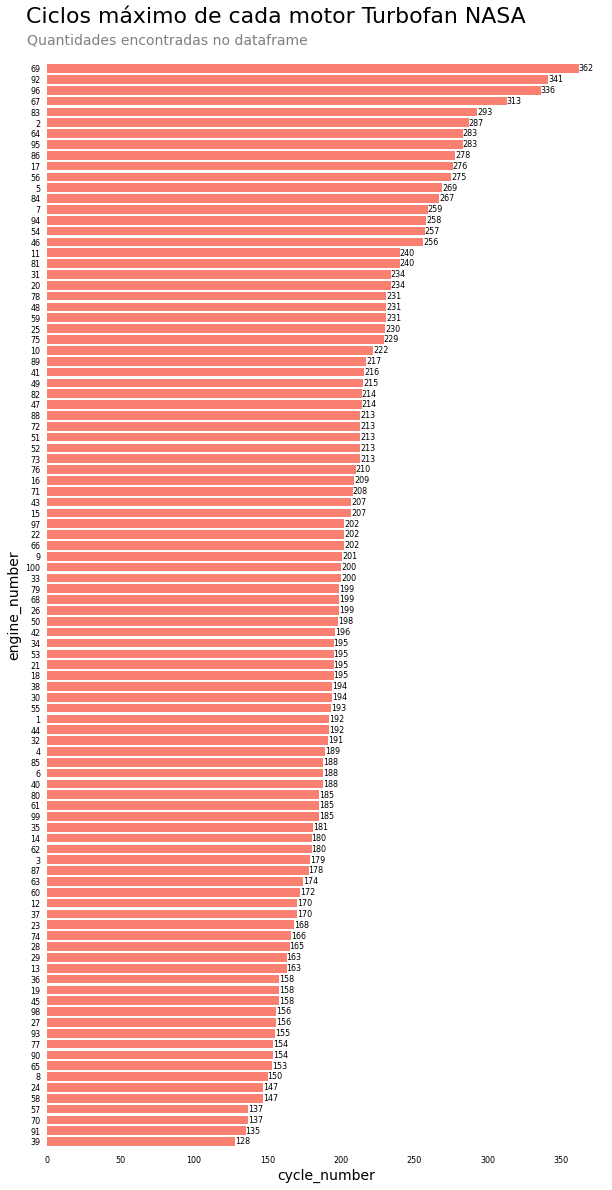

In [ ]:
# agrupando porcentagem de cada tipo de imóveis e classificando
y = df_train[index_names].groupby('engine_number').max().sort_values(by="cycle_number", ascending=True)
y = y.squeeze()

# gerando os elementos do gráfico de barras
fig, ax = plt.subplots(figsize=(10,20))
y.plot(kind="barh", ax=ax, color='salmon', width=0.8)
plt.title("Ciclos máximo de cada motor Turbofan NASA", fontsize=22, x=0.41, y=1.03)
plt.suptitle("Quantidades encontradas no dataframe", color = "gray", fontsize= 14, x=0.292, y=0.90)
plt.xlabel('cycle_number',size=14)
plt.xticks(size=8)
plt.ylabel('engine_number',size=14)
plt.yticks(size=8)

# adicionando valores nas barras
for index, value in enumerate(y): 
    plt.text(value, index, str(value), color="black", verticalalignment="center", fontsize=8) 

# definindo visibilidade de parâmetros
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True) 
plt.tick_params(axis='y', which='both', right=False, left=False, labelleft=True) 
for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False)
ax.legend_ = None

**Traçando a evolução dos sensores ao longo da vida útil dos motores**

Nestes gráficos iremos demonstrar a caracterização dos dados de sensores ao longo da vida restante dos motores `RUL`, ou seja indicando o valor de cada sensor em cada respectivo ciclo do motor. Primeiramente foi definida a função que define os parâmetros do gráfico e na sequência os dados dos sensores em cada momento do ciclo de vida dos sensores.

In [ ]:
# adicionando RUL aos dados de treino
def add_RUL_column(df):
    train_grouped_by_unit = df.groupby(by='engine_number') 
    max_cycle = train_grouped_by_unit['cycle_number'].max() 
    merged = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='engine_number',right_index=True)
    merged["RUL"] = merged["max_cycle"] - merged['cycle_number']
    merged = merged.drop("max_cycle", axis=1) 
    return merged
df_train_RUL = add_RUL_column(df_train)

In [ ]:
# gerando função com parâmetros do gráfico
def plot_sensor(sensor_name,X):
    plt.figure(figsize=(12,3))
    for i in X['engine_number'].unique():
        if (i % 10 == 0):
            plt.plot('RUL', sensor_name, data=X[X['engine_number']==i])          
    plt.xlim(250, 0)
    plt.xticks(np.arange(0, 300, 25))
    plt.ylabel(sensor_name)
    plt.xlabel('Remaining_Useful_Life')
    plt.show()

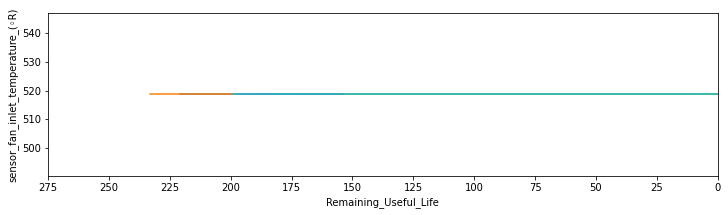

In [ ]:
plot_sensor('sensor_fan_inlet_temperature_(◦R)',df_train_RUL)

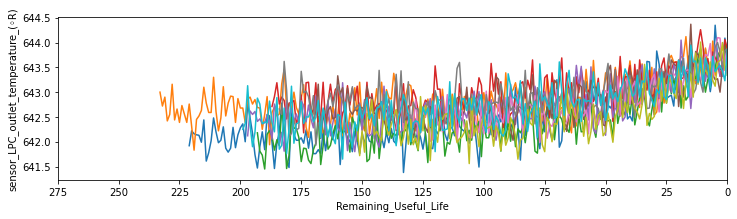

In [ ]:
plot_sensor('sensor_LPC_outlet_temperature_(◦R)',df_train_RUL)

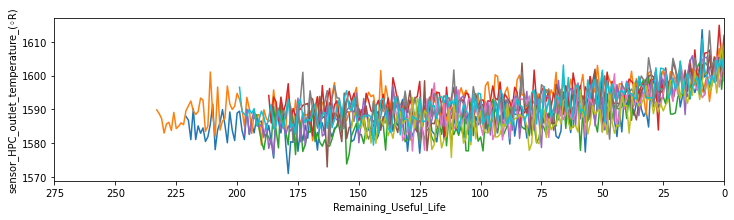

In [ ]:
plot_sensor('sensor_HPC_outlet_temperature_(◦R)',df_train_RUL)

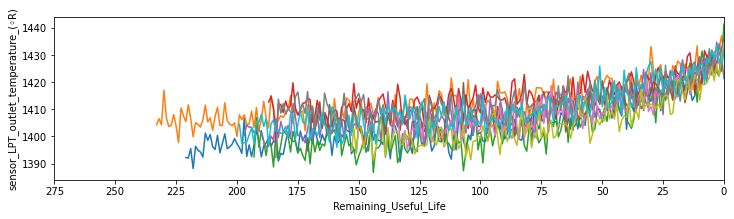

In [ ]:
plot_sensor('sensor_LPT_outlet_temperature_(◦R)',df_train_RUL)

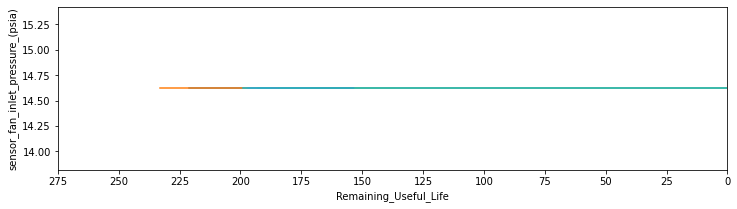

In [ ]:
plot_sensor('sensor_fan_inlet_pressure_(psia)',df_train_RUL)

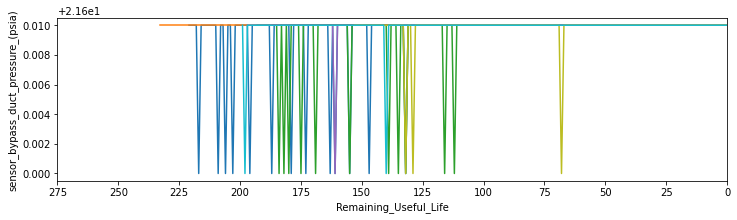

In [ ]:
plot_sensor('sensor_bypass_duct_pressure_(psia)',df_train_RUL)

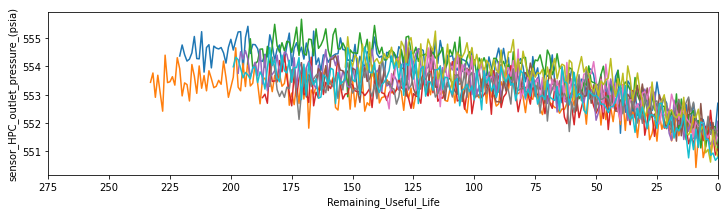

In [ ]:
plot_sensor('sensor_HPC_outlet_pressure_(psia)',df_train_RUL)

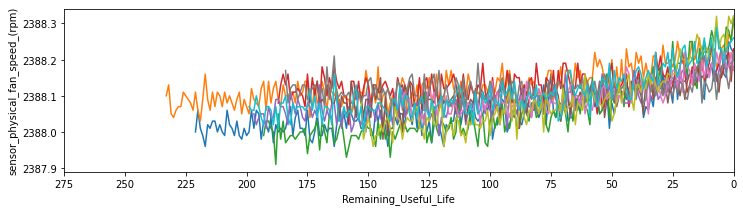

In [ ]:
plot_sensor('sensor_physical_fan_speed_(rpm)',df_train_RUL)

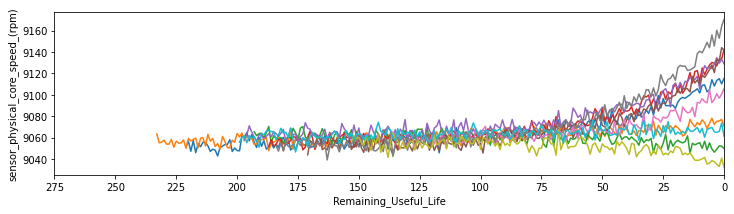

In [ ]:
plot_sensor('sensor_physical_core_speed_(rpm)',df_train_RUL)

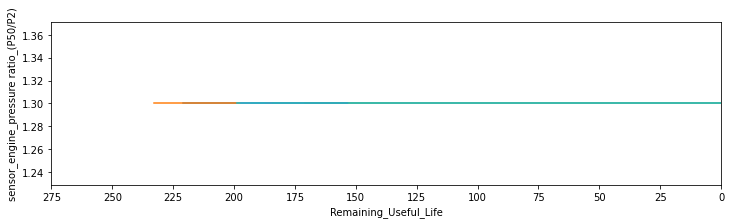

In [ ]:
plot_sensor('sensor_engine_pressure ratio_(P50/P2)',df_train_RUL)

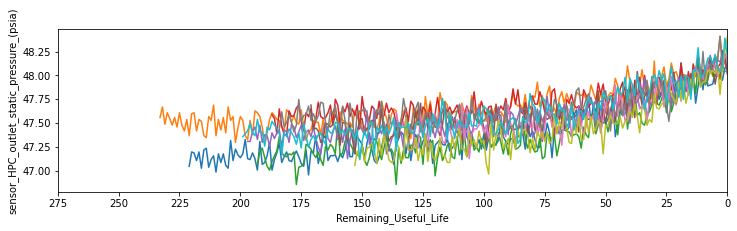

In [ ]:
plot_sensor('sensor_HPC_outlet_static_pressure_(psia)',df_train_RUL)

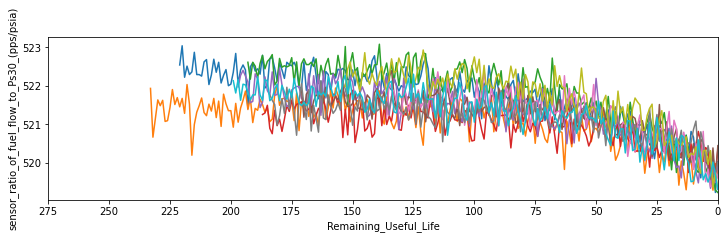

In [ ]:
plot_sensor('sensor_ratio_of_fuel_flow_to_Ps30_(pps/psia)',df_train_RUL)

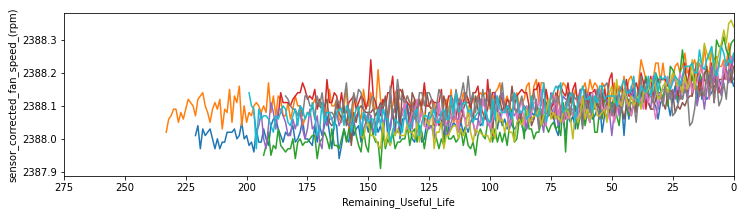

In [ ]:
plot_sensor('sensor_corrected_fan_speed_(rpm)',df_train_RUL)

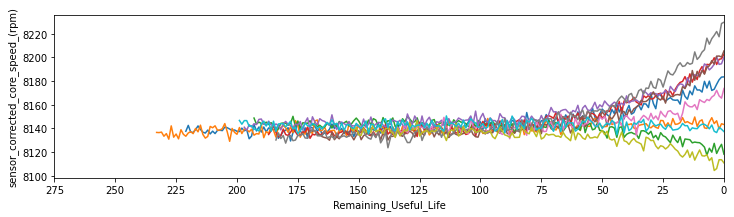

In [ ]:
plot_sensor('sensor_corrected_core_speed_(rpm)',df_train_RUL)

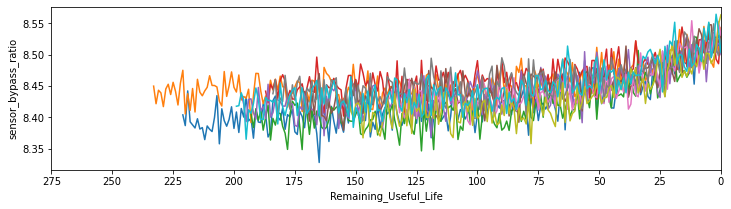

In [ ]:
plot_sensor('sensor_bypass_ratio',df_train_RUL)

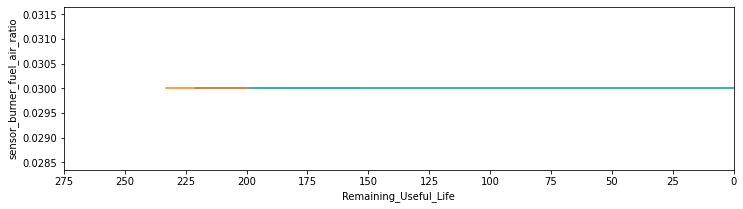

In [ ]:
plot_sensor('sensor_burner_fuel_air_ratio',df_train_RUL)

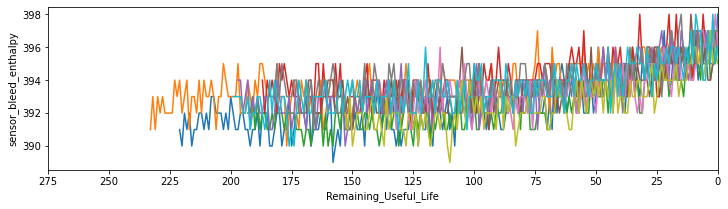

In [ ]:
plot_sensor('sensor_bleed_enthalpy',df_train_RUL)

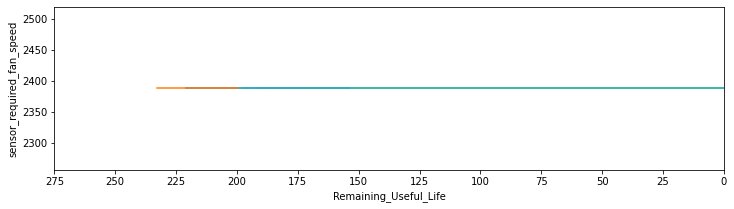

In [ ]:
plot_sensor('sensor_required_fan_speed',df_train_RUL)

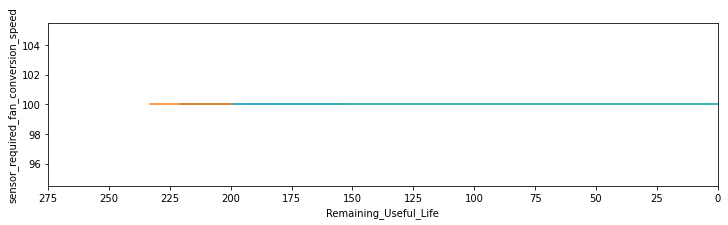

In [ ]:
plot_sensor('sensor_required_fan_conversion_speed',df_train_RUL)

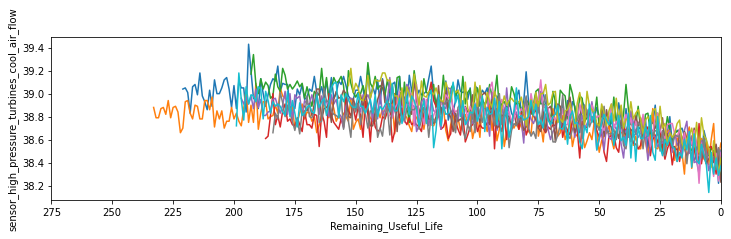

In [ ]:
plot_sensor('sensor_high_pressure_turbines_cool_air_flow',df_train_RUL)

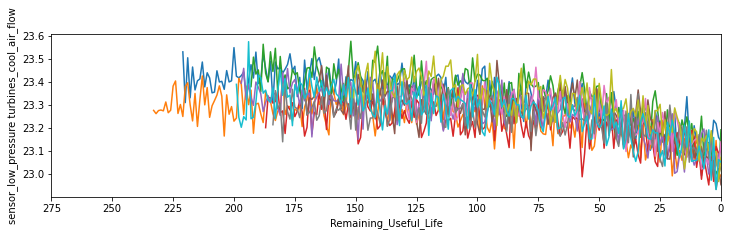

In [ ]:
plot_sensor('sensor_low_pressure turbines_cool_air_flow',df_train_RUL)

Esses gráficos mostram que alguns sensores são constantes. Portanto, eles não influenciam o RUL e desta forma iremos desconsiderá-los.

###**Distribuições**

Agora vamos ver a distribuição das classes do dataset. Para identificar se os nossos dados podem estar com algum tipo de bias (viés) e tirar alguns *insights* do negócio. É possível ver abaixo, que não há indícios da presença de outliers, um indicativo de que os dados estão adequadamente ajustados para o modelo.

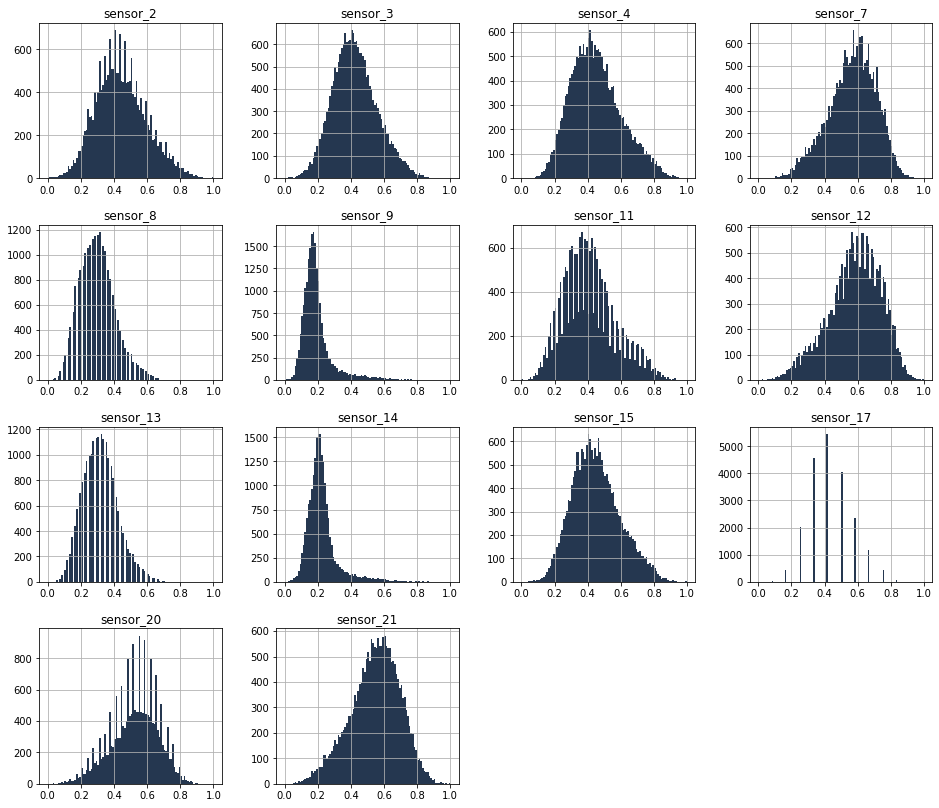

In [ ]:
# eliminando features desnecessários
drop_labels = index_names+setting_names
sensors_train = df_train.drop(columns=drop_labels)

# selecionando os sensores dos gráficos e desconsiderando sensores com RUL constantes
sensor_names=['sensor_{}'.format(i) for i in range(1,22) if i not in [1,5,6,10,16,18,19]]

# ajustando escala dos dados
scaler = MinMaxScaler()
sensors_train = scaler.fit_transform(sensors_train)

# gerando os gráficos
pd.DataFrame(sensors_train,columns=['sensor_{}'.format(i) for i in range(1,22)])[sensor_names].hist(bins=100, figsize=(16,14), color= "#253750");

###**Correlações**

No nosso contexto, estamos buscando **relação ou semelhança entre duas variáveis**. Essa relação pode ser medida, e é função do coeficiente de correlação estabelecer qual a intensidade dela. **Um ponto importante a ser destacado é a diferenciação entre correlação e causalidade**, como é bem descrito [neste artigo](https://towardsdatascience.com/correlation-is-not-causation-ae05d03c1f53), para termos uma análise exploratória dos dados mais assertiva.

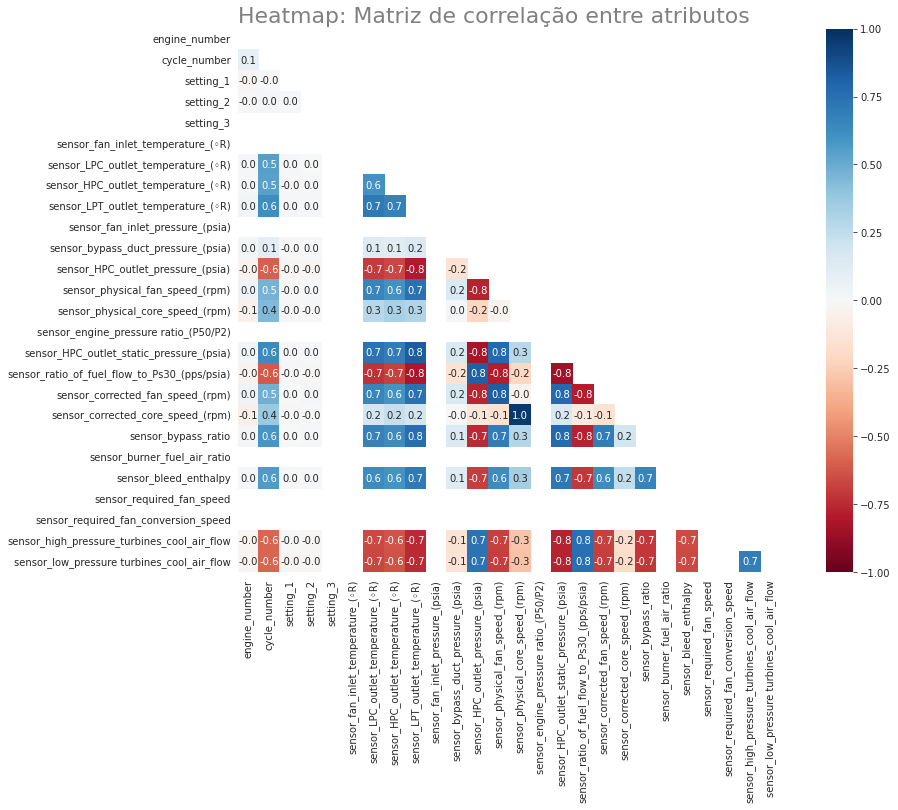

In [ ]:
# criando a matriz de correlação
corr = df_train.corr()

# plotar um heatmap a partir das correlações
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

# definindo parâmetros
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(16, 10))
    ax = sns.heatmap(corr, cmap='RdBu', fmt='.1f', mask=mask, vmax=1, vmin=-1, square=True, annot=True)

# adicionando títulos
plt.title("Heatmap: Matriz de correlação entre atributos", fontsize=22, color = "gray", loc="left");

# Preparando os dados

Esta etapa consiste em preparar nosso conjunto de dados para a construção do modelo. Nesta seção, diversos tipos de tratamento dos dados como: **limpeza dos dados, *feature engineering*, seleção de atributos e spliting data**.

O tratamento dos dados relacionado à ***Feature Scaling*** será aplicado na etapa de Otimização do Modelo de Machine Learning deste estudo, pois nesta etapa poderemos avaliar o efeito de cada tipo de scaling sobre o desempenho dos modelos. Desta forma, aplicando *scaling* nesta etapa teremos mais assertividade quanto à escolha do tipo de ajuste.

###**Limpeza dos dados**

Nesta etapa serão realizadas algumas verificações para identificar possíveis dados discrepantes e para que assim possamos ajustá-los, como valores ausentes e valores duplicados.

**Valores ausentes**

Na função abaixo, conseguimos verificar que não há valores ausentes neste *dataframe*.

In [ ]:
# checando os valores ausentes
(df_train.isnull().sum() / df_train.shape[0]).sort_values(ascending=False)

engine_number                                   0.0
cycle_number                                    0.0
sensor_high_pressure_turbines_cool_air_flow     0.0
sensor_required_fan_conversion_speed            0.0
sensor_required_fan_speed                       0.0
sensor_bleed_enthalpy                           0.0
sensor_burner_fuel_air_ratio                    0.0
sensor_bypass_ratio                             0.0
sensor_corrected_core_speed_(rpm)               0.0
sensor_corrected_fan_speed_(rpm)                0.0
sensor_ratio_of_fuel_flow_to_Ps30_(pps/psia)    0.0
sensor_HPC_outlet_static_pressure_(psia)        0.0
sensor_engine_pressure ratio_(P50/P2)           0.0
sensor_physical_core_speed_(rpm)                0.0
sensor_physical_fan_speed_(rpm)                 0.0
sensor_HPC_outlet_pressure_(psia)               0.0
sensor_bypass_duct_pressure_(psia)              0.0
sensor_fan_inlet_pressure_(psia)                0.0
sensor_LPT_outlet_temperature_(◦R)              0.0
sensor_HPC_o

In [ ]:
# checando os valores ausentes
(df_test.isnull().sum() / df_train.shape[0]).sort_values(ascending=False)

engine_number                                   0.0
cycle_number                                    0.0
sensor_high_pressure_turbines_cool_air_flow     0.0
sensor_required_fan_conversion_speed            0.0
sensor_required_fan_speed                       0.0
sensor_bleed_enthalpy                           0.0
sensor_burner_fuel_air_ratio                    0.0
sensor_bypass_ratio                             0.0
sensor_corrected_core_speed_(rpm)               0.0
sensor_corrected_fan_speed_(rpm)                0.0
sensor_ratio_of_fuel_flow_to_Ps30_(pps/psia)    0.0
sensor_HPC_outlet_static_pressure_(psia)        0.0
sensor_engine_pressure ratio_(P50/P2)           0.0
sensor_physical_core_speed_(rpm)                0.0
sensor_physical_fan_speed_(rpm)                 0.0
sensor_HPC_outlet_pressure_(psia)               0.0
sensor_bypass_duct_pressure_(psia)              0.0
sensor_fan_inlet_pressure_(psia)                0.0
sensor_LPT_outlet_temperature_(◦R)              0.0
sensor_HPC_o

**Valores duplicados**

Esta é uma etapa importante à ser verificada para reduzirmos os ruídos neste tipo de trabalho. Como podemos observar abaixo, o *dataframe* não apresentou dados duplicados, desta forma o podemos seguir para próxima etapa.

In [ ]:
# verificando a existência de dados duplicados
duplicated = df_train[df_train.duplicated().values]
duplicated

,engine_number,cycle_number,setting_1,setting_2,setting_3,sensor_fan_inlet_temperature_(◦R),sensor_LPC_outlet_temperature_(◦R),sensor_HPC_outlet_temperature_(◦R),sensor_LPT_outlet_temperature_(◦R),sensor_fan_inlet_pressure_(psia),...,sensor_ratio_of_fuel_flow_to_Ps30_(pps/psia),sensor_corrected_fan_speed_(rpm),sensor_corrected_core_speed_(rpm),sensor_bypass_ratio,sensor_burner_fuel_air_ratio,sensor_bleed_enthalpy,sensor_required_fan_speed,sensor_required_fan_conversion_speed,sensor_high_pressure_turbines_cool_air_flow,sensor_low_pressure turbines_cool_air_flow


In [ ]:
# verificando a existência de dados duplicados
duplicated = df_test[df_test.duplicated().values]
duplicated

,engine_number,cycle_number,setting_1,setting_2,setting_3,sensor_fan_inlet_temperature_(◦R),sensor_LPC_outlet_temperature_(◦R),sensor_HPC_outlet_temperature_(◦R),sensor_LPT_outlet_temperature_(◦R),sensor_fan_inlet_pressure_(psia),...,sensor_ratio_of_fuel_flow_to_Ps30_(pps/psia),sensor_corrected_fan_speed_(rpm),sensor_corrected_core_speed_(rpm),sensor_bypass_ratio,sensor_burner_fuel_air_ratio,sensor_bleed_enthalpy,sensor_required_fan_speed,sensor_required_fan_conversion_speed,sensor_high_pressure_turbines_cool_air_flow,sensor_low_pressure turbines_cool_air_flow


###**Feature Engineering**

As técnicas de *feature engineering* para *machine learning* é um tópico fundamental no aprendizado de máquina, é o termo utilizado para definir um conjunto de técnicas utilizado na criação e manipulação de features (recursos). Porém, *feature engineering* não se trata apenas de selecionar bons recursos para um modelo, esse processo também abrange a transformação matemática nas features existentes para extrair o máximo potencial dos dados e criação de novas features.

In [ ]:
# adicionando RUL aos dados de treino
df_train_RUL = df_train.groupby(['engine_number']).agg({'cycle_number':'max'})
df_train_RUL.rename(columns={'cycle_number':'life'},inplace=True)
df_train = df_train.merge(df_train_RUL,how='left',on=['engine_number'])
df_train['RUL']=df_train['life']-df_train['cycle_number']
df_train.drop(['life'],axis=1,inplace=True)
# df_train['RUL'][df_train['RUL']>200]=200 # ativar regressão e desativar classificação
df_train[['engine_number', 'cycle_number', 'RUL']]

,engine_number,cycle_number,RUL
0,1,1,191
1,1,2,190
2,1,3,189
3,1,4,188
4,1,5,187
...,...,...,...
20626,100,196,4
20627,100,197,3
20628,100,198,2
20629,100,199,1


In [ ]:
# preparando o dataframe de teste
df_test_cycle = df_test.groupby(['engine_number']).agg({'cycle_number':'max'})
df_test_cycle.rename(columns={'cycle_number':'life'},inplace=True)
df_test = df_test.merge(df_test_cycle,how='left',on=['engine_number'])
df_test = df_test[(df_test['cycle_number']==df_test['life'])]
df_test.drop(['life'],axis=1,inplace=True)

# adicionando RUL aos dados de teste
RUL = df_test_RUL["RUL"]
df_test = df_test.reset_index(drop=True)
df_test = df_test.join(RUL)
df_test[['engine_number', 'cycle_number', 'RUL']]

,engine_number,cycle_number,RUL
0,1,31,112
1,2,49,98
2,3,126,69
3,4,106,82
4,5,98,91
...,...,...,...
95,96,97,137
96,97,134,82
97,98,121,59
98,99,97,117


In [ ]:
# armazenando dados do motor
df_engine_number = df_test

###**Seleção de atributos**

Com a limpeza dos dados, agora podemos fazer a seleção das *features* do nosso *dataframe* eliminando e preservando os dados para que os objetivos propostos ao estudo sejam alcançados:

In [ ]:
# listando features desnecessárias
index_names = ['engine_number']

sensor_names=[ "sensor_fan_inlet_temperature_(◦R)",
            "sensor_fan_inlet_pressure_(psia)",
            "sensor_bypass_duct_pressure_(psia)",
            "sensor_engine_pressure ratio_(P50/P2)",
            "sensor_burner_fuel_air_ratio",
            "sensor_required_fan_speed",
            "sensor_required_fan_conversion_speed"]

# eliminando features desnecessários
drop_labels = index_names + setting_names + sensor_names
df_train = df_train.drop(columns=drop_labels)
df_test = df_test.drop(columns=drop_labels)

In [ ]:
# verificando os nomes das colunas utiizadas
df_columns = list(df_train.drop('RUL', axis=1).select_dtypes(exclude='object').columns)
df_columns

['cycle_number',
 'sensor_LPC_outlet_temperature_(◦R)',
 'sensor_HPC_outlet_temperature_(◦R)',
 'sensor_LPT_outlet_temperature_(◦R)',
 'sensor_HPC_outlet_pressure_(psia)',
 'sensor_physical_fan_speed_(rpm)',
 'sensor_physical_core_speed_(rpm)',
 'sensor_HPC_outlet_static_pressure_(psia)',
 'sensor_ratio_of_fuel_flow_to_Ps30_(pps/psia)',
 'sensor_corrected_fan_speed_(rpm)',
 'sensor_corrected_core_speed_(rpm)',
 'sensor_bypass_ratio',
 'sensor_bleed_enthalpy',
 'sensor_high_pressure_turbines_cool_air_flow',
 'sensor_low_pressure turbines_cool_air_flow']

###**Spliting data**

Lembre-se que os dados de teste não podem ser usados para treinar o modelo. Quando estivermos com nosso modelo pronto, aí sim, usaremos o modelo de teste para fazer previsões. Com isso, vamos separar os dados entre X e Y como entre treino e test aplicando a técnica conhecida como `split`.

In [ ]:
# dividindo os dados entre treino e teste
X_train = df_train.drop('RUL', axis=1).select_dtypes(exclude='object')
y_train = df_train['RUL']
X_test = df_test.drop('RUL', axis=1).select_dtypes(exclude='object')
y_test = df_test['RUL']

# Modelos de Regressão para RUL

**Métrica dos modelos**

As métricas retornadas para modelos de regressão são projetadas para estimar a quantidade de erros. Um modelo é considerado adequado para os dados se a diferença entre os valores observados e previstos for pequena. No entanto, observar o padrão dos resíduos (a diferença entre qualquer ponto previsto e seu valor real correspondente) pode fornecer muitas informações sobre o desvio potencial de um modelo.

O que vai definir a melhor métrica é a estratégia de negócio da empresa e seus valores, [*neste artigo*](https://towardsdatascience.com/what-are-the-best-metrics-to-evaluate-your-regression-model-418ca481755b) podemos analisar com mais profundidade algumas das principais métricas de regressão. Já para este estudo utilizei as seguintes métricas:

* `Coeficiente de determinação (R²)`: representa o poder de previsão do modelo como um valor entre 0 e 1, onde o escore de 1 indicaria um modelo capaz de explicar toda a variância. No entanto, raramente deve ser usado isoladamente para estimar o desempenho de um modelo, pois não fornece nenhuma medida de viés. Portanto, é possível ter um alto valor de R² para um modelo com alto viés.

* `Raiz do quadrado médio (RMSE)`: é essencialmente uma medida de quão espalhados esses resíduos estão, e é uma maneira padrão de quantificar o erro geral para um modelo de regressão, quanto menor seu valor melhor é o modelo. Uma desvantagem potencial desta métrica é que, devido ao método de cálculo, penalizará grandes erros e outliers mais do que outras métricas. 

* `Erro absoluto médio (MAE)`: é outra medida de quão longe os valores previstos estão dos valores observados, assim, quanto menor esse valor, melhor. Diferentemente do RMSE, essa métrica não penaliza tão severamente os erros maiores e outliers.


###**Comparação de modelos**

Agora irei comparar o desempenho de vários modelos a fim de identificar e escolher o melhor. Primeiramente elaborei um modelo base line simples, sem qualquer tipo de ajuste ou técnicas, e na sequência apliquei diversos ajustes e técnicas com o objetivo de se obter um melhor desempenho dos modelos. As métricas de avaliação serão as mesmas definidas inicialmente e os modelos a serem comparados serão:

* XGBoost Regression (XGB)
* Extra Trees Regressor (ETR)
* LightGBM Regression (LGBM)
* Random Forest Regressor (RFR)
* Linear Regression (LRN)
* Ridge Regression (RDG)
* Lasso Regression (LSR)
* k Nearest Neighbors Regressior (kNN)

In [ ]:
# gerando dataframe comparativo de métricas dos modelos
model_performance = pd.DataFrame(columns=['R²','RMSE', 'MAE'])

**Base line**

Com o processamento realizado na etapa anterior, os dados já podem ser usados nos modelos de machine learning. Para podermos comparar o desempenho e melhorar o modelo, criaremos um baseline simples, não será feito nenhum ajuste nos hiperparâmetros e nem será aplicado técnicas como *cross validation* ou *scaling*.

In [ ]:
# instanciando o modelo
model_xgb = XGBRegressor(verbosity = 0).fit(X_train,y_train)

# fazendo previsão
y_predictions = model_xgb.predict(X_test)

# adicionando dados ao dataframe das métricas dos modelos
model_performance.loc['XGB base line'] = [model_xgb.score(X_test,y_test), mean_squared_error(y_test,y_predictions,squared=False), mean_absolute_error(y_test, y_predictions)]

# visualizando o desempenho do modelo com dados normalizados
print('R-squared error (R²): '+ "{:.4f}".format(model_xgb.score(X_test,y_test)))
print('Root Mean Squared Error (RMSE): '+ "{:.3f}".format(mean_squared_error(y_test,y_predictions,squared=False)))
print('Mean Absolute Error (MAE): '+ "{:.3f}".format(mean_absolute_error(y_test, y_predictions)))

R-squared error (R²): 0.6963
Root Mean Squared Error (RMSE): 22.900
Mean Absolute Error (MAE): 16.368


Para os modelos a seguir apliquei a técnica de *cross validation*.

**XGBoost Regression (XGB)**

In [ ]:
# instanciando o modelo
model_xgb = XGBRegressor(verbosity = 0).fit(X_train,y_train)

# gerando cross validation
scores_xgb = cross_val_score(model_xgb, X_train, y_train, cv=5)

# fazendo previsão
y_predictions = model_xgb.predict(X_test)

# adicionando dados ao dataframe das métricas dos modelos
model_performance.loc['XGBoost Regression (XGB)'] = [scores_xgb.mean(), mean_squared_error(y_test,y_predictions,squared=False), mean_absolute_error(y_test, y_predictions)]

# visualizando o desempenho do modelo com dados normalizados
print('R-squared error (R²): '+ "{:.4f}".format(scores_xgb.mean()))
print('Root Mean Squared Error (RMSE): '+ "{:.3f}".format(mean_squared_error(y_test,y_predictions,squared=False)))
print('Mean Absolute Error (MAE): '+ "{:.3f}".format(mean_absolute_error(y_test, y_predictions)))

R-squared error (R²): 0.7634
Root Mean Squared Error (RMSE): 22.900
Mean Absolute Error (MAE): 16.368


**Extra Trees Regressor (ETR)**

In [ ]:
# instanciando o modelo
model_etr = ExtraTreesRegressor().fit(X_train,y_train)

# gerando cross validation
scores_etr = cross_val_score(model_etr, X_train, y_train, cv=5)

# fazendo previsão
y_predictions = model_etr.predict(X_test)

# adicionando dados ao dataframe das métricas dos modelos
model_performance.loc['Extra Trees Regressor (ETR)'] = [scores_etr.mean(), mean_squared_error(y_test,y_predictions,squared=False), mean_absolute_error(y_test, y_predictions)]

# visualizando o desempenho do modelo com dados normalizados
print('R-squared error (R²): '+ "{:.4f}".format(scores_etr.mean()))
print('Root Mean Squared Error (RMSE): '+ "{:.3f}".format(mean_squared_error(y_test,y_predictions,squared=False)))
print('Mean Absolute Error (MAE): '+ "{:.3f}".format(mean_absolute_error(y_test, y_predictions)))

R-squared error (R²): 0.7607
Root Mean Squared Error (RMSE): 23.470
Mean Absolute Error (MAE): 17.886


**LightGBM Regression (LGBM)**

In [ ]:
# instanciando o modelo
model_lgbm = LGBMRegressor().fit(X_train,y_train)

# gerando cross validation
scores_lgbm = cross_val_score(model_lgbm, X_train, y_train, cv=5)

# fazendo previsão
y_predictions = model_lgbm.predict(X_test)

# adicionando dados ao dataframe das métricas dos modelos
model_performance.loc['LightGBM Regression (LGBM)'] = [scores_lgbm.mean(), mean_squared_error(y_test,y_predictions,squared=False), mean_absolute_error(y_test, y_predictions)]

# visualizando o desempenho do modelo com dados normalizados
print('R-squared error (R²): '+ "{:.4f}".format(scores_lgbm.mean()))
print('Root Mean Squared Error (RMSE): '+ "{:.3f}".format(mean_squared_error(y_test,y_predictions,squared=False)))
print('Mean Absolute Error (MAE): '+ "{:.3f}".format(mean_absolute_error(y_test, y_predictions)))

R-squared error (R²): 0.7574
Root Mean Squared Error (RMSE): 24.536
Mean Absolute Error (MAE): 18.444


**Random Forest Regressor (RFR)**

In [ ]:
# instanciando o modelo
model_rfr = RandomForestRegressor().fit(X_train,y_train)

# gerando cross validation
scores_rfr = cross_val_score(model_rfr, X_train, y_train, cv=5)

# fazendo previsão
y_predictions = model_rfr.predict(X_test)

# adicionando dados ao dataframe das métricas dos modelos
model_performance.loc['Random Forest Regressor (RFR)'] = [scores_rfr.mean(), mean_squared_error(y_test,y_predictions,squared=False), mean_absolute_error(y_test, y_predictions)]

# visualizando o desempenho do modelo com dados normalizados
print('R-squared error (R²): '+ "{:.4f}".format(scores_rfr.mean()))
print('Root Mean Squared Error (RMSE): '+ "{:.3f}".format(mean_squared_error(y_test,y_predictions,squared=False)))
print('Mean Absolute Error (MAE): '+ "{:.3f}".format(mean_absolute_error(y_test, y_predictions)))

R-squared error (R²): 0.7570
Root Mean Squared Error (RMSE): 24.611
Mean Absolute Error (MAE): 18.674


**Linear Regression (LRN)**

In [ ]:
# instanciando o modelo
model_lrn = LinearRegression().fit(X_train,y_train)

# gerando cross validation
scores_lrn = cross_val_score(model_lrn, X_train, y_train, cv=5)

# fazendo previsão
y_predictions = model_lrn.predict(X_test)

# adicionando dados ao dataframe das métricas dos modelos
model_performance.loc['Linear Regression (LRN)'] = [scores_lrn.mean(), mean_squared_error(y_test,y_predictions,squared=False), mean_absolute_error(y_test, y_predictions)]

# visualizando o desempenho do modelo com dados normalizados
print('R-squared error (R²): '+ "{:.4f}".format(scores_lrn.mean()))
print('Root Mean Squared Error (RMSE): '+ "{:.3f}".format(mean_squared_error(y_test,y_predictions,squared=False)))
print('Mean Absolute Error (MAE): '+ "{:.3f}".format(mean_absolute_error(y_test, y_predictions)))

R-squared error (R²): 0.6924
Root Mean Squared Error (RMSE): 28.486
Mean Absolute Error (MAE): 23.466


**Ridge Regression (RDG)**

In [ ]:
# instanciando o modelo
model_rdg = Ridge().fit(X_train,y_train)

# gerando cross validation
scores_rdg = cross_val_score(model_rdg, X_train, y_train, cv=5)

# fazendo previsão
y_predictions = model_rdg.predict(X_test)

# adicionando dados ao dataframe das métricas dos modelos
model_performance.loc['Ridge Regression (RDG)'] = [scores_rdg.mean(), mean_squared_error(y_test,y_predictions,squared=False), mean_absolute_error(y_test, y_predictions)]

# visualizando o desempenho do modelo com dados normalizados
print('R-squared error (R²): '+ "{:.4f}".format(scores_rdg.mean()))
print('Root Mean Squared Error (RMSE): '+ "{:.3f}".format(mean_squared_error(y_test,y_predictions,squared=False)))
print('Mean Absolute Error (MAE): '+ "{:.3f}".format(mean_absolute_error(y_test, y_predictions)))

R-squared error (R²): 0.6924
Root Mean Squared Error (RMSE): 28.485
Mean Absolute Error (MAE): 23.460


**Lasso Regression (LSR)**

In [ ]:
# instanciando o modelo
model_lsr = Lasso().fit(X_train,y_train)

# gerando cross validation
scores_lsr = cross_val_score(model_lsr, X_train, y_train, cv=5)

# fazendo previsão
y_predictions = model_lsr.predict(X_test)

# adicionando dados ao dataframe das métricas dos modelos
model_performance.loc['Lasso Regression (LSR)'] = [scores_lsr.mean(), mean_squared_error(y_test,y_predictions,squared=False), mean_absolute_error(y_test, y_predictions)]

# visualizando o desempenho do modelo com dados normalizados
print('R-squared error (R²): '+ "{:.4f}".format(scores_lsr.mean()))
print('Root Mean Squared Error (RMSE): '+ "{:.3f}".format(mean_squared_error(y_test,y_predictions,squared=False)))
print('Mean Absolute Error (MAE): '+ "{:.3f}".format(mean_absolute_error(y_test, y_predictions)))

R-squared error (R²): 0.6826
Root Mean Squared Error (RMSE): 30.571
Mean Absolute Error (MAE): 24.865


**k Nearest Neighbors Regressor (kNN)**

In [ ]:
# instanciando o modelo
model_knn = KNeighborsRegressor().fit(X_train,y_train)

# gerando cross validation
scores_knn = cross_val_score(model_knn, X_train, y_train, cv=5)

# fazendo previsão
y_predictions = model_knn.predict(X_test)

# adicionando dados ao dataframe das métricas dos modelos
model_performance.loc['k Nearest Neighbors Regressor (kNN)'] = [scores_knn.mean(), mean_squared_error(y_test,y_predictions,squared=False), mean_absolute_error(y_test, y_predictions)]

# visualizando o desempenho do modelo com dados normalizados
print('R-squared error (R²): '+ "{:.4f}".format(scores_knn.mean()))
print('Root Mean Squared Error (RMSE): '+ "{:.3f}".format(mean_squared_error(y_test,y_predictions,squared=False)))
print('Mean Absolute Error (MAE): '+ "{:.3f}".format(mean_absolute_error(y_test, y_predictions)))

R-squared error (R²): 0.6779
Root Mean Squared Error (RMSE): 30.383
Mean Absolute Error (MAE): 23.236


**Escolha do modelo**

Ao realizar os testes com diferentes modelos, podemos ver que o `XGBRegressor`retornou os melhores resultados nas métricas. Devido ao seu resultado inicial, iremos seguir com ele buscando uma melhoria em seu desempenho através de ajustes de hiperparâmetros.

In [ ]:
# visualizando o comparativo de modelos
model_performance.style.background_gradient(axis=0, gmap=model_performance['R²'], cmap='Blues').format({'R²':'{:.4f}', 'RMSE':'{:.3f}', 'MAE':'{:.3f}'})

,R²,RMSE,MAE
XGB base line,0.6963,22.900,16.368
XGB,0.7634,22.900,16.368
ETR,0.7607,23.470,17.886
LGBM,0.7574,24.536,18.444
RFR,0.7570,24.611,18.674
LRN,0.6924,28.486,23.466
RDG,0.6924,28.485,23.460
LSR,0.6826,30.571,24.865
KNN,0.6779,30.383,23.236


###**Otimização do modelo**

**Feature Scaling**

Nesta etapa apliquei a técnica conhecida como *Scaling*, esta técnica tem como objetivo ajustar a magnitude dos diferentes *featuring*. Para implementarmos as técnicas de *Scaling* podemos aplicar tanto a Normalização com o `MinMaxScaler()`, como a Padronização com o `StandardScaler()`, estas são as duas técnicas de dimensionamento de recursos mais importantes e comumente utilizada. Neste [*link*](https://towardsdatascience.com/normalization-vs-standardization-cb8fe15082eb) é possível acessar mais informações desta técnica.

In [ ]:
# # normalizando os dados
# scaler = MinMaxScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

In [ ]:
# # instanciando o modelo
# model_xgb = XGBRegressor(verbosity = 0).fit(X_train,y_train)

# # gerando cross validation
# scores_xgb = cross_val_score(model_xgb, X_train, y_train, cv=5)

# # fazendo previsão
# y_predictions = model_xgb.predict(X_test)

# # visualizando o desempenho do modelo com dados normalizados
# print('R-squared error (R²): '+ "{:.4f}".format(scores_xgb.mean()))
# print('Root Mean Squared Error (RMSE): '+ "{:.3f}".format(mean_squared_error(y_test,y_predictions,squared=False)))
# print('Mean Absolute Error (MAE): '+ "{:.3f}".format(mean_absolute_error(y_test, y_predictions)))

R-squared error (R²): 0.7634
Root Mean Squared Error (RMSE): 22.900
Mean Absolute Error (MAE): 16.368


In [ ]:
# # padronizando os dados
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

In [ ]:
# # instanciando o modelo
# model_xgb = XGBRegressor(verbosity = 0).fit(X_train,y_train)

# # gerando cross validation
# scores_xgb = cross_val_score(model_xgb, X_train, y_train, cv=5)

# # fazendo previsão
# y_predictions = model_xgb.predict(X_test)

# # visualizando o desempenho do modelo com dados normalizados
# print('R-squared error (R²): '+ "{:.4f}".format(scores_xgb.mean()))
# print('Root Mean Squared Error (RMSE): '+ "{:.3f}".format(mean_squared_error(y_test,y_predictions,squared=False)))
# print('Mean Absolute Error (MAE): '+ "{:.3f}".format(mean_absolute_error(y_test, y_predictions)))

R-squared error (R²): 0.7634
Root Mean Squared Error (RMSE): 22.900
Mean Absolute Error (MAE): 16.368


Acima podemos ver, que os modelos de *scaling* não apresentaram efeito sobre a performance do modelo, sendo assim seguiremos com os dados do *dataframe* sem *scaling* nas etapas seguintes deste estudo.

**Otimização de hiperparâmetros**

As duas técnicas de otimização dos hiperparâmnetros mais comuns são o *Random Search* e o *Grid Search*. Considerando o número de combinações de parâmetros escolhidos, optei por utilizar o *Grid Search*, pois a sua lógica de funcionamento oferece mais combinações, o que poderá nos fornecer uma melhor recomendação de hiperparâmetros.

Este otimizador de hiperparâmetros é uma pesquisa em grade sobre cada combinação de valores de parâmetros especificados. Acesse este [*link*](https://towardsdatascience.com/a-practical-introduction-to-grid-search-random-search-and-bayes-search-d5580b1d941d) para mais informação sobre as diferenças de otimizadores e seus respectivos funcionamentos, assim como os parâmetros de otimização disponíveis no modelo XGBoost [*aqui*](https://xgboost.readthedocs.io/en/stable/parameter.html).

In [ ]:
# verificando os parâmetros originais do modelo XGB Regressor
model_xgb.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'importance_type': 'gain',
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'reg:linear',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbosity': 0}

In [ ]:
# instanciando o modelo
model_xgb = XGBRegressor(verbosity = 0)

# definindo os parâmetros a serem testados
parameters = {
  'colsample_bylevel':[0.01, 0.6, 1],
  'max_depth':[1, 4, 6],
  'n_estimators':[0, 10, 100],
  'subsample':[0.1, 0.2, 1.0],
  }

# identificando os melhores parâmetros
scorer = make_scorer(r2_score)
kfold = StratifiedKFold(n_splits=3, shuffle=True)
grid_search = GridSearchCV(model_xgb, parameters, scoring=scorer, n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train, y_train)

# vendo os resultados
# print("Melhores Parâmetros:{}".format(grid_result.best_params_))
print("R²: {:.4f} com os seguintes parâmetros {}".format(grid_result.best_score_, grid_result.best_params_))

R²: 0.7887 com os seguintes parâmetros {'colsample_bylevel': 0.6, 'max_depth': 6, 'n_estimators': 100, 'subsample': 1.0}


In [ ]:
# instanciando o modelo
model_xgb = XGBRegressor(verbosity = 0, colsample_bylevel = 0.6, max_depth = 4, n_estimators = 100, subsample = 1.0).fit(X_train,y_train)

# gerando cross validation
scores_xgb = cross_val_score(model_xgb, X_train, y_train, cv=5)

# fazendo previsão
y_predictions = model_xgb.predict(X_test)

# visualizando o desempenho do modelo com dados normalizados
print('R-squared error (R²): '+ "{:.4f}".format(scores_xgb.mean()))
print('Root Mean Squared Error (RMSE): '+ "{:.3f}".format(mean_squared_error(y_test,y_predictions,squared=False)))
print('Mean Absolute Error (MAE): '+ "{:.3f}".format(mean_absolute_error(y_test, y_predictions)))

R-squared error (R²): 0.7638
Root Mean Squared Error (RMSE): 23.297
Mean Absolute Error (MAE): 17.252


Acima podemos ver a combinação de parâmetos que obtiveram o melhor desempenho sobre os dados de treino se comparado ao desempenho da etapas anteriores. Fato é que todos esses hiperprâmetros ajustados, conseguiram melhorar o desempenho do modelo XGBoost.

###**Avaliação de desempenho**

**Prediction Error Plot**

O `prediction_error` plota o conjunto de dados alvo real (actual) em relação aos valores previstos pelo modelo (predicted). Isso nos permite ver quanta variação há no modelo. Podemos diagnosticar modelos de regressão usando esse gráfico comparando com a linha de 45 graus, onde a previsão corresponde exatamente ao modelo.

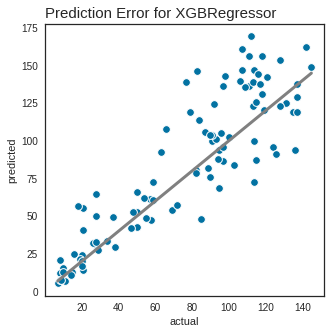

In [ ]:
# gerando gráfico do modelo somente RUL
plt.rcParams['figure.figsize']=5,5
fig,ax = plt.subplots()
plt.title('Prediction Error for XGBRegressor', size=15, loc="left")
plt.xlabel('actual')
plt.ylabel('predicted')
g = sns.scatterplot(x=y_test, y=y_predictions, s=60, alpha=1, linewidth=1, ax=ax)
f = sns.lineplot(x=[min(y_test),max(y_test)], y=[min(y_test),max(y_test)], linewidth=3, color='gray', ax=ax)

**Actual vs Predicted Plot**

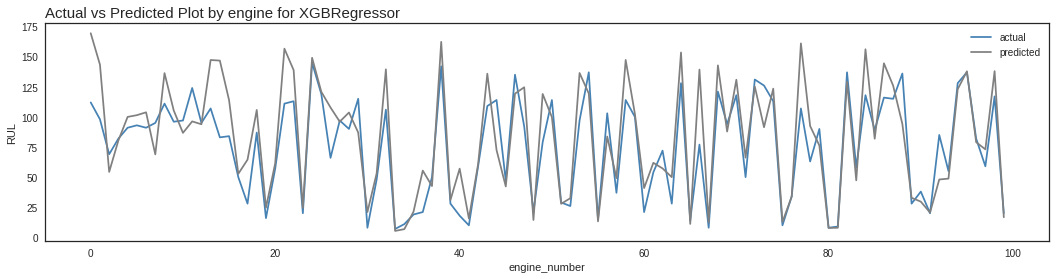

In [ ]:
# gerando gráfico do modelo RUL por motor
plt.style.use('seaborn-white')
plt.rcParams['figure.figsize']=18,4
fig,ax = plt.subplots()
plt.title('Actual vs Predicted Plot by engine for XGBRegressor', size=15, loc="left")
plt.ylabel('RUL')
plt.xlabel('engine_number')
g = sns.lineplot(x = np.arange(0,len(df_train['engine_number'].unique())), y=y_test, color='steelblue', label = 'actual', ax=ax)
f = sns.lineplot(x = np.arange(0,len(df_train['engine_number'].unique())), y=y_predictions, color='gray', label = 'predicted', ax=ax)

**Feature importance - Summary Plot**

O gráfico abaixo classifica os recursos pela soma das magnitudes do valor em todas as amostras e usa os valores para mostrar a distribuição dos impactos que cada recurso tem na saída do modelo. A cor representa o valor do recurso (vermelho é alto, azul é baixo). Para este estudo, usei a biblioteca *shap*, esta é uma biblioteca muito poderosa em *feature importance*. Para mais informações, acesse esse o [*link*](https://towardsdatascience.com/a-novel-approach-to-feature-importance-shapley-additive-explanations-d18af30fc21b). 



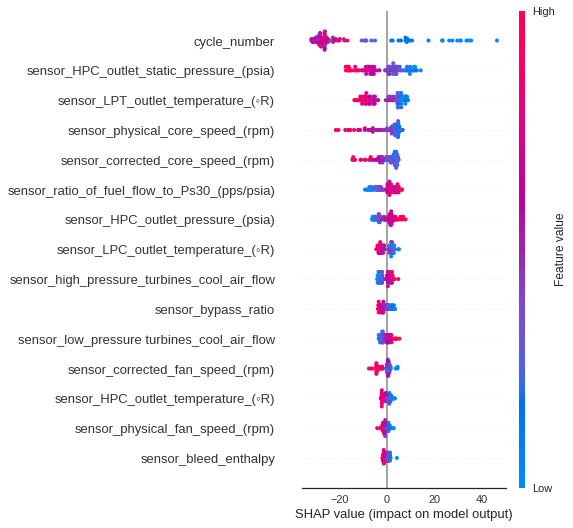

In [ ]:
# gerando o gráfico
explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=df_columns)

**Feature importance - Summary Bar Plot**

Também podemos simplesmente tomar o valor absoluto médio dos valores de cada recurso para obter um gráfico de barras padrão. Este gráfico pode ser gerado através da função `plot_type="bar"`; esta função produz barras empilhadas de várias classes, priorizando-as por relevância:

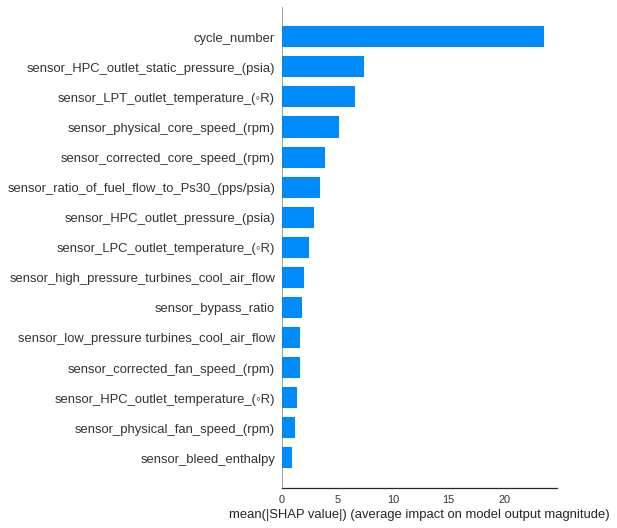

In [ ]:
# gerando o gráfico
shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names=df_columns)

Conforme podemos ver, esses gráficos nos dizem quais recursos são os mais importantes para um modelo e, portanto, podemos tornar nossos modelos de aprendizado de máquina mais interpretáveis e explicativos.

###**Finalizando o modelo**

**Análise dos dados gerado pelo modelo**

Aqui podemos visualizar tanto os dados gerados pelo modelo de regressão desenvolvido neste estudo como os dados reais do nosso *dataset* original. Neste *dataframe* conseguimos fazer uma comparação visual destes dados. Na coluna `RUL actual` conseguimos ver o número de ciclos restantes (RUL) para cada motor segundo os dados do dataframe, já na coluna `RUL predicted` conseguimos ver os números de ciclos restantes (RUL) para cada motor segundo o modelo desenvolvido.

In [ ]:
# gerando novo dataframe de output comparativo
output = pd.DataFrame({'engine_number':df_engine_number.engine_number, 'RUL actual':y_test, 'RUL predicted':y_predictions}).set_index('engine_number')
output['RUL predicted'] = output['RUL predicted'].astype(int)
output

,RUL actual,RUL predicted
engine_number,,
1,112,169
2,98,143
3,69,54
4,82,80
5,91,99
...,...,...
96,137,137
97,82,79
98,59,73


**Salvando o Modelo**

Agora que terminamos nosso trabalho com o modelo, é hora de se preocupar em como mantê-lo utilizável e pronto para fazer novas previsões em novos dados. Com a função `joblib.dump` conseguimos salvar o nosso modelo treinado, pronto para uso. Dentro dele também está contido todo o pipeline de pré-processamento que foi utilizado. Basta passar o conjunto de dados para fazer as previsões.

In [ ]:
# salvando o modelo como um pickle em um arquivo
joblib.dump(model_xgb, 'regression_RUL.pkl')

['regression.pkl']

# Modelos de Classificação para RUL

Conforme o objetivos proposto neste estudo, desenvolvi um modelo de classificação como forma de categorização dos motores sob as seguintes classes de RUL: risco alto e baixo de falha dos motores. Para isso primeiramente dividi o dataframe em 2 categorias com frequência similares de bins, na sequência desenvolvi todo o modelo conforme as premissas estabelecidas pelo estudo.

**Preparando os dados do modelo de classificação**

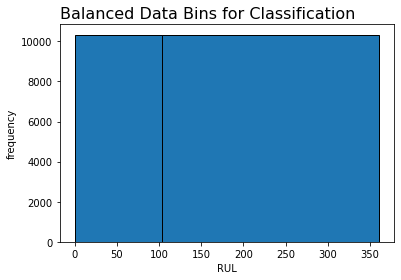

[  0. 103. 361.]


In [ ]:
# definindo função para calcular frequências iguais de bins, bins=3
def equalObs(x, nbin):
    nlen = len(x)
    return np.interp(np.linspace(0, nlen, nbin + 1), np.arange(nlen), np.sort(x))

# criando histogram com frequências iguais de bins 
plt.rcParams['figure.figsize']=6,4
plt.title('Balanced Data Bins for Classification', size=16, loc="left")
plt.ylabel('frequency')
plt.xlabel('RUL')
n, bins, patches = plt.hist(list(df_train['RUL']), equalObs(list(df_train['RUL']), 2), edgecolor='black')
plt.show()
print(bins)

O resultado da categorização demonstrou que podemos criar classes de RUL e transformar nosso problema em um problema de classificação. A prioridade será dada para bins que nos dão classes balanceadas. Neste modelo estaremos trabalhando com a última versão dos dados tratados, com alguns sensores já descartados.

Vamos classificar entre 2 classes de RUL:

(0) para RISCO BAIXO, com RUL entre 104 e 361;

(1) para RISCO ALTO, com RUL entre 0 e 103.

In [ ]:
# criando funcção de categorizando dos RUL
label_map={1:"RISK ZONE",2:"MODERATED RISK",3:"NO RISK"}
y=[]

for k in df_train['RUL']:
    if k<=103:
        y.append(0)
    else:
        y.append(1)

# aplicando função de categorização e spliting sobre os dados
X_train, X_test, y_train, y_test=train_test_split(df_train.drop(columns=['RUL']),np.array(y), test_size=0.35, stratify=np.array(y))

# # transformando dados em séries
y_train = pd.Series(y_train)
y_test = pd.Series(y_test)

In [ ]:
# gerando a lista de valores únicos
print("Valores únicos de RUL: {}".format(y_train.nunique()))

Valores únicos de RUL: 2


In [ ]:
# gerando a lista de valores únicos
print("Valores únicos de RUL: {}".format(y_test.nunique()))

Valores únicos de RUL: 2


**Métrica dos modelos**

Para decidirmos que métrica usar, precisamos analisar algumas de nossas opções:

* `Accuracy`: caso optemos por otimizar o modelo por essa métrica precisamos estar cientes que esse pode não ser o método ideal, mas para uma análise inicial do problema, essa métrica pode nos ajudar a criar uma solução generalista.

* `Recall`: o ajuste do modelo apartir dele visa priorizar que não hajam Falsos Negativos. Ou seja, é preferível negar um cliente que não traria prejuízo à empresa, do que aceitar um que traga. Essa é a forma que são tratados, por exemplo, fraudes em cartão de crédito, modelos médicos, etc.

* `Precision`: com essa métrica, essencialmente, estamos dizendo que Falsos Positivos são ok, e não queremos ter Falsos Negativos. Basicamente, é preferível aceitar clientes que possam trazer prejuízo, do que deixar de aceitar clientes que não trarão. Essa é a forma que são tratados, por exemplo, modelos para spam de e-mails. Esta métrica é preferível quando tratamos de dados desbalanceados.

O que vai definir a melhor métrica é a estratégia de negócio da empresa, e seus valores. Já para este estudo utilizei o `Accuracy` como métrica de escolha do modelo, no intuito de realizar uma análise generalista. Na sequência para a otimização do modelo escolhido, utilizei como métrica alvo o `Recall`, no intuito de realizar uma melhoria de desempenho quanto aos Falsos Negativos.


In [ ]:
# gerando dataframe de métricas dos modelos
model_performance = pd.DataFrame(columns=['Accuracy','Recall', 'Precision'])

# gerando dataframe de métricas dos modelos com melhorias de desempenho
model_performance_optimization = pd.DataFrame(columns=['Recall', 'Accuracy', 'Precision'])

###**Comparação de modelos**

Nesta etapa faço uma comparação de desempenho de vários modelos a fim de identificar e escolher o melhor. Primeiramente elanoro um modelo base line simples, sem qualquer tipo de ajuste ou técnicas, e na sequência aplico diversos ajustes e técnicas com o objetivo de se obter um melhor desempenho dos modelos. As métricas de avaliação serão as definidas inicialmente e os modelos a serem comparados serão:

* LightGBM Classifier (LGBMC)
* Random Forest Classifier (RFC)
* XGBoost Classifier (XGBC)
* Decision Tree Classifier (DTC)
* Support Vector Classifier (SVC)
* k Nearest Neighbors Classifier (kNNC)
* Naive Bayes Classifier (NBC)
* Logistic Regression Classifier (LRC)


**Random Forest Classifier (RFC)**

In [ ]:
# instanciando o modelo
model_rfc = RandomForestClassifier().fit(X_train,y_train)

# gerando cross validation
scores_rfc = cross_val_score(model_rfc, X_train, y_train, cv=5)

# fazendo previsão
y_predictions = model_rfc.predict(X_test)

# adicionando dados ao dataframe das métricas dos modelos
model_performance.loc['Random Forest Classifier (RFC)'] = [accuracy_score(y_test, y_predictions), recall_score(y_test, y_predictions), precision_score(y_test, y_predictions)]
model_performance_optimization.loc['Random Forest Classifier (RFC)'] = [recall_score(y_test, y_predictions), accuracy_score(y_test, y_predictions), precision_score(y_test, y_predictions)]

# visualizando o desempenho do modelo com dados normalizados
print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_predictions)))
print("Recall: {:.4f}".format(recall_score(y_test, y_predictions)))
print("Precision: {:.4f}".format(precision_score(y_test, y_predictions)))

Accuracy: 0.8694
Recall: 0.8855
Precision: 0.8561


**LightGBM Classifier (LGBMC)**

In [ ]:
# instanciando o modelo
model_lgbmc = LGBMClassifier().fit(X_train,y_train)

# gerando cross validation
scores_lgbmc = cross_val_score(model_lgbmc, X_train, y_train, cv=5)

# fazendo previsão
y_predictions = model_lgbmc.predict(X_test)

# adicionando dados ao dataframe das métricas dos modelos
model_performance.loc['LightGBM Classifier (LGBMC)'] = [accuracy_score(y_test, y_predictions), recall_score(y_test, y_predictions), precision_score(y_test, y_predictions)]

# visualizando o desempenho do modelo com dados normalizados
print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_predictions)))
print("Recall: {:.4f}".format(recall_score(y_test, y_predictions)))
print("Precision: {:.4f}".format(precision_score(y_test, y_predictions)))

Accuracy: 0.8682
Recall: 0.8897
Precision: 0.8512


**XGBoost Classifier (XGBC)**

In [ ]:
# instanciando o modelo
model_xgbc = XGBClassifier().fit(X_train,y_train)

# gerando cross validation
scores_xgbc = cross_val_score(model_xgbc, X_train, y_train, cv=5)

# fazendo previsão
y_predictions = model_xgbc.predict(X_test)

# adicionando dados ao dataframe das métricas dos modelos
model_performance.loc['XGBoost Classifier (XGBC)'] = [accuracy_score(y_test, y_predictions), recall_score(y_test, y_predictions), precision_score(y_test, y_predictions)]

# visualizando o desempenho do modelo com dados normalizados
print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_predictions)))
print("Recall: {:.4f}".format(recall_score(y_test, y_predictions)))
print("Precision: {:.4f}".format(precision_score(y_test, y_predictions)))

Accuracy: 0.8673
Recall: 0.8894
Precision: 0.8500


**k Nearest Neighbors Classifier (kNNC)**

In [ ]:
# instanciando o modelo
model_knnc = KNeighborsClassifier().fit(X_train,y_train)

# gerando cross validation
scores_knnc = cross_val_score(model_knnc, X_train, y_train, cv=5)

# fazendo previsão
y_predictions = model_knnc.predict(X_test)

# adicionando dados ao dataframe das métricas dos modelos
model_performance.loc['k Nearest Neighbors Classifier (kNNC)'] = [accuracy_score(y_test, y_predictions), recall_score(y_test, y_predictions), precision_score(y_test, y_predictions)]

# visualizando o desempenho do modelo com dados normalizados
print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_predictions)))
print("Recall: {:.4f}".format(recall_score(y_test, y_predictions)))
print("Precision: {:.4f}".format(precision_score(y_test, y_predictions)))

Accuracy: 0.8514
Recall: 0.8699
Precision: 0.8369


**Logistic Regression Classifier (LRC)**

In [ ]:
# instanciando o modelo
model_lrc = LogisticRegression().fit(X_train,y_train)

# gerando cross validation
scores_lrc = cross_val_score(model_lrc, X_train, y_train, cv=5)

# fazendo previsão
y_predictions = model_lrc.predict(X_test)

# adicionando dados ao dataframe das métricas dos modelos
model_performance.loc['Logistic Regression Classifier (LRC)'] = [accuracy_score(y_test, y_predictions), recall_score(y_test, y_predictions), precision_score(y_test, y_predictions)]

# visualizando o desempenho do modelo com dados normalizados
print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_predictions)))
print("Recall: {:.4f}".format(recall_score(y_test, y_predictions)))
print("Precision: {:.4f}".format(precision_score(y_test, y_predictions)))

Accuracy: 0.8511
Recall: 0.8743
Precision: 0.8336


**Naive Bayes Classifier (NBC)**

In [ ]:
# instanciando o modelo
model_nbc = GaussianNB().fit(X_train,y_train)

# gerando cross validation
scores_nbc = cross_val_score(model_nbc, X_train, y_train, cv=5)

# fazendo previsão
y_predictions = model_nbc.predict(X_test)

# adicionando dados ao dataframe das métricas dos modelos
model_performance.loc['Naive Bayes Classifier (NBC)'] = [accuracy_score(y_test, y_predictions), recall_score(y_test, y_predictions), precision_score(y_test, y_predictions)]

# visualizando o desempenho do modelo com dados normalizados
print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_predictions)))
print("Recall: {:.4f}".format(recall_score(y_test, y_predictions)))
print("Precision: {:.4f}".format(precision_score(y_test, y_predictions)))

Accuracy: 0.8194
Recall: 0.9017
Precision: 0.7723


**Decision Tree Classifier (DTC)**

In [ ]:
# instanciando o modelo
model_dtc = DecisionTreeClassifier().fit(X_train,y_train)

# gerando cross validation
scores_dtc = cross_val_score(model_dtc, X_train, y_train, cv=5)

# fazendo previsão
y_predictions = model_dtc.predict(X_test)

# adicionando dados ao dataframe das métricas dos modelos
model_performance.loc['Decision Tree Classifier (DTC)'] = [accuracy_score(y_test, y_predictions), recall_score(y_test, y_predictions), precision_score(y_test, y_predictions)]

# visualizando o desempenho do modelo com dados normalizados
print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_predictions)))
print("Recall: {:.4f}".format(recall_score(y_test, y_predictions)))
print("Precision: {:.4f}".format(precision_score(y_test, y_predictions)))

Accuracy: 0.8190
Recall: 0.8216
Precision: 0.8150


**Support Vector Classifier (SVC)**

In [ ]:
# instanciando o modelo
model_svc = SVC().fit(X_train,y_train)

# gerando cross validation
scores_svc = cross_val_score(model_svc, X_train, y_train, cv=5)

# fazendo previsão
y_predictions = model_svc.predict(X_test)

# adicionando dados ao dataframe das métricas dos modelos
model_performance.loc['Support Vector Classifier (SVC)'] = [accuracy_score(y_test, y_predictions), recall_score(y_test, y_predictions), precision_score(y_test, y_predictions)]

# visualizando o desempenho do modelo com dados normalizados
print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_predictions)))
print("Recall: {:.4f}".format(recall_score(y_test, y_predictions)))
print("Precision: {:.4f}".format(precision_score(y_test, y_predictions)))

Accuracy: 0.7957
Recall: 0.9051
Precision: 0.7406


**Escolha do modelo**

Ao realizar os testes com diferentes modelos, podemos ver que o `XGBRegressor`retornou os melhores resultados nas métricas. Devido ao seu resultado inicial, iremos seguir com ele buscando uma melhoria em seu desempenho atravé de ajustes de hiperparâmetros.

In [ ]:
# visualizando o comparativo de modelos
model_performance.style.background_gradient(axis=0, gmap=model_performance['Accuracy'], cmap='Blues').format({'Recall':'{:.4f}', 'Accuracy':'{:.4f}', 'Precision':'{:.4f}'})

,Accuracy,Recall,Precision
Random Forest Classifier (RFC),0.8694,0.8855,0.8561
LightGBM Classifier (LGBMC),0.8682,0.8897,0.8512
XGBoost Classifier (XGBC),0.8673,0.8894,0.8500
k Nearest Neighbors Classifier (kNNC),0.8514,0.8699,0.8369
Logistic Regression Classifier (LRC),0.8511,0.8743,0.8336
Naive Bayes Classifier (NBC),0.8194,0.9017,0.7723
Decision Tree Classifier (DTC),0.8190,0.8216,0.8150
Support Vector Classifier (SVC),0.7957,0.9051,0.7406


###**Otimização do modelo**

**Feature Scaling**

Nesta etapa apliquei a técnica conhecida como *Scaling*, esta técnica tem como objetivo ajustar a magnitude dos diferentes *featuring*. Para implementarmos as técnicas de *Scaling* podemos aplicar tanto a Normalização com o `MinMaxScaler()`, como a Padronização com o `StandardScaler()`, estas são as duas técnicas de dimensionamento de recursos mais importantes e comumente utilizada. Neste [*link*](https://towardsdatascience.com/normalization-vs-standardization-cb8fe15082eb) é possível acessar mais informações destas técnicas.

In [ ]:
# # normalizando os dados
# scaler = MinMaxScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

In [ ]:
# # instanciando o modelo
# model_rfc = RandomForestClassifier().fit(X_train,y_train)

# # gerando cross validation
# scores_rfc = cross_val_score(model_rfc, X_train, y_train, cv=5)

# # fazendo previsão
# y_predictions = model_rfc.predict(X_test)

# # adicionando dados ao dataframe das métricas dos modelos
# model_performance.loc['Random Forest Classifier (RFC)'] = [accuracy_score(y_test, y_predictions), recall_score(y_test, y_predictions), precision_score(y_test, y_predictions)]

# # visualizando o desempenho do modelo com dados normalizados
# print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_predictions)))
# print("Recall: {:.4f}".format(recall_score(y_test, y_predictions)))
# print("Precision: {:.4f}".format(precision_score(y_test, y_predictions)))

Accuracy: 0.8614
Recall: 0.8674
Precision: 0.8552


In [ ]:
# padronizando os dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# instanciando o modelo
model_rfc = RandomForestClassifier().fit(X_train,y_train)

# gerando cross validation
scores_rfc = cross_val_score(model_rfc, X_train, y_train, cv=5)

# fazendo previsão
y_predictions = model_rfc.predict(X_test)

# visualizando o desempenho do modelo com dados normalizados
print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_predictions)))
print("Recall: {:.4f}".format(recall_score(y_test, y_predictions)))
print("Precision: {:.4f}".format(precision_score(y_test, y_predictions)))

Accuracy: 0.8697
Recall: 0.8861
Precision: 0.8562


In [ ]:
# adicionando dados ao dataframe de otimização do modelo
model_performance_optimization.loc['Random Forest Classifier (RFC) - Scaling'] = [recall_score(y_test, y_predictions), accuracy_score(y_test, y_predictions), precision_score(y_test, y_predictions)]


Acima podemos ver, que o modelo de *scaling* que apresentou melhor desempenho de `Recall`foi do tipo padronizado (`StandardScaler()`), sendo assim esta técnica será a escolhida para os dados nas etapas seguintes.

**Otimização de hiperparâmetros**

As duas técnicas de otimização dos hiperparâmnetros mais comuns são o *Random Search* e o *Grid Search*. Considerando o número de combinações de parâmetros escolhidos, optei por utilizar o *Grid Search*, pois a sua lógica de funcionamento oferece mais combinações, o que poderá nos fornecer uma melhor recomendação de hiperparâmetros. Este otimizador de hiperparâmetros é uma pesquisa em grade sobre cada combinação de valores de parâmetros especificados. Acesse este [*link*](https://towardsdatascience.com/a-practical-introduction-to-grid-search-random-search-and-bayes-search-d5580b1d941d) para mais informação sobre as diferenças de otimizadores e seus respectivos funcionamentos.

In [ ]:
# verificando os parâmetros originais do modelo XGB Regressor
model_rfc.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [ ]:
# instanciando o modelo
model_rfc = RandomForestClassifier()

# definindo os parâmetros a serem testados
parameters = {
  'max_depth':[1, 4, 6],
  'min_samples_leaf':[0.01, 0.6, 1],
  'n_estimators':[0, 10, 100],
  }

# identificar melhores parâmetros
kfold = StratifiedKFold(n_splits=3, shuffle=True)
random_search = RandomizedSearchCV(model_rfc, parameters, scoring="recall", n_jobs=-1, cv=kfold)
random_result = random_search.fit(X_train, y_train)

# ver resultados
print("Melhor Recall: {:.4f} para {}".format(random_result.best_score_, random_result.best_params_))

Melhor Recall: 0.9033 para {'n_estimators': 100, 'min_samples_leaf': 1, 'max_depth': 4}


In [ ]:
# instanciando o modelo
model_rfc = RandomForestClassifier(n_estimators = 100, min_samples_leaf = 0.01, max_depth = 1).fit(X_train,y_train)

# gerando cross validation
scores_rfc = cross_val_score(model_rfc, X_train, y_train, cv=5)

# fazendo previsão
y_predictions = model_rfc.predict(X_test)

# visualizando o desempenho do modelo com dados normalizados
print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_predictions)))
print("Recall: {:.4f}".format(recall_score(y_test, y_predictions)))
print("Precision: {:.4f}".format(precision_score(y_test, y_predictions)))

Accuracy: 0.8078
Recall: 0.9073
Precision: 0.7547


In [ ]:
# adicionando dados ao dataframe de otimização do modelo
model_performance_optimization.loc['Random Forest Classifier (RFC) - Scaling + Hyperparameter'] = [recall_score(y_test, y_predictions), accuracy_score(y_test, y_predictions), precision_score(y_test, y_predictions)]


Como podemos ver, com os ajustes de *scaling* e hiperparâmetros conseguimos melhorar o desempenho do `Recall` do modelo classificador de RUL escolhido, conforme premissas definidas inicialmente.

In [ ]:
# visualizando o comparativo de modelos
model_performance_optimization.style.background_gradient(axis=0, gmap=model_performance['Recall'], cmap='Blues').format({'Recall':'{:.4f}', 'Accuracy':'{:.4f}', 'Precision':'{:.4f}'})

,Recall,Accuracy,Precision
Random Forest Classifier (RFC),0.8855,0.8694,0.8561
Random Forest Classifier (RFC) - Scaling,0.8861,0.8697,0.8562
Random Forest Classifier (RFC) - Scaling + Hyperparameter,0.9073,0.8078,0.7547


###**Avaliação de desempenho**

**Confusion Matrix**

Com a função `confusion_matrix`, conseguimos visualizar as frequências de classificação para cada classe do modelo, considerando os dados alvo real (True label) e em relação aos valores previstos pelo modelo (Predicted label). Isso nos permite saber o quão bem o modelo prevê as classes.

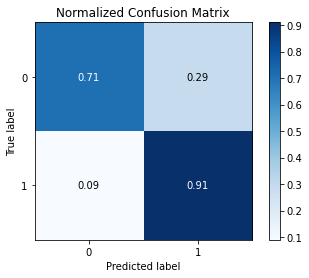

In [ ]:
# plotando confusion matrix
plot_confusion_matrix(y_test, y_predictions, normalize=True)
plt.show()

**Classification Report**

In [ ]:
# gerando o classification report
print(classification_report(y_test, y_predictions))

              precision    recall  f1-score   support

           0       0.89      0.71      0.79      3640
           1       0.75      0.91      0.82      3581

    accuracy                           0.81      7221
   macro avg       0.82      0.81      0.81      7221
weighted avg       0.82      0.81      0.81      7221



**Feature importance - Summary Plot**

O gráfico abaixo classifica os recursos pela soma das magnitudes do valor em todas as amostras e usa os valores para mostrar a distribuição dos impactos que cada recurso tem sobre a saída do modelo, com isso, podemos tornar nossos modelos de aprendizado de máquina mais interpretáveis e explicativos.

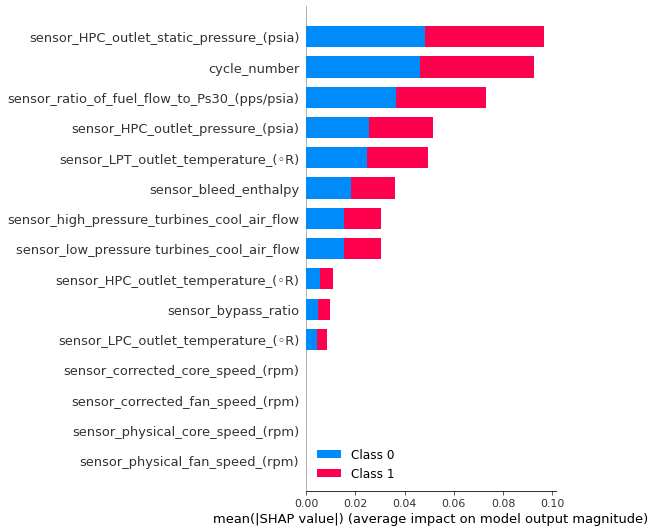

In [ ]:
# gerando o gráfico
explainer = shap.TreeExplainer(model_rfc)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=df_columns)

###**Finalizando o modelo**

**Análise dos dados gerado pelo modelo**

Aqui podemos visualizar tanto os dados gerados pelo modelo de classificação (`RUL class predicted`) desenvolvido neste estudo como os dados reais do nosso *dataset* original (`RUL class actual`), neste *dataframe* conseguimos fazer uma comparação visual destes dados, onde 0 indica a categoria risco baixo de falha e 1 risco alto de falha dos motores.

In [ ]:
# gerando novo dataframe de output comparativo
output = pd.DataFrame({'RUL class actual':y_test, 'RUL class predicted':y_predictions})
output['RUL class predicted'] = output['RUL class predicted'].astype(int)
output

,RUL class actual,RUL class predicted
0,0,1
1,0,0
2,0,0
3,1,1
4,1,1
...,...,...
7216,1,1
7217,0,0
7218,0,0
7219,0,1


**Salvando o Modelo**

Agora que terminamos nosso trabalho com o modelo, é hora de se preocupar em como mantê-lo utilizável e pronto para fazer novas previsões em novos dados. Com a função `joblib.dump` conseguimos salvar o nosso modelo treinado, pronto para uso. Dentro dele também está contido todo o pipeline de pré-processamento que foi utilizado. Basta passar o conjunto de dados para fazer as previsões.

In [ ]:
# salvando o modelo como um pickle em um arquivo
joblib.dump(model_rfc, 'classification_RUL.pkl')

['classification_RUL.pkl']